In [1]:
import matplotlib.pyplot as plt
import mygene
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# TCGA Preprocessing Summary

- **Load data**: Import mRNA expression (TPM) and clinical files, merge by sample ID.  
- **Filter**: Remove non-drug treatments (e.g., vaccines, “Other”) and toxicity-stopped cases.  
- **Labeling**: Convert treatment outcomes into RECIST labels (CR/PR=1, SD/PD=0, else=Unknown).  
- **Deduplicate**: Keep unique (project, case, diagnosis, treatment) entries.  
- **Expression processing**:  
  - Apply log2(TPM+1)  
  - Remove all-zero genes  
  - Select top 5000 most variable genes  
  - Gene-wise z-score normalization (mean 0, std 1)  
  - Cast to float32  
- **Save outputs**:  
  - `gene_exp.csv.gz` (expression matrix)  
  - `patients_info.csv.gz` (clinical + label info)  
- **Summary/visualization**: Count drug frequencies and plot drug × project heatmap.  


In [2]:
important_cols = [
    "project.project_id",
    "cases.submitter_id",
    "diagnoses.primary_diagnosis",
    "treatments.treatment_outcome",
    "treatments.therapeutic_agents",
]

In [3]:
non_smiles_compounds = [
    "Not Reported",
    "Other",
    "Clinical Trial",
    "Clinical Trial Agent",
    "Hormone Therapy",
    "Total Androgen Blockade",
    "Dendritic Cell Vaccine",
    "PEP-3-KLH Conjugate Vaccine",
    "Antineoplastic Vaccine",
    "Multi-glioblastoma-peptide-targeting Autologous Dendritic Cell Vaccine ICT-107",
    "MAGE-A3 Peptide Vaccine",
    "AE37 Peptide/GM-CSF Vaccine",
    "Recombinant PRAME Protein Plus AS15 Adjuvant GSK2302025A",
    "Recombinant MAGE-3.1 Antigen",
    "Innate Immunostimulator rBBX-01",
    "Recombinant Adenovirus-p53 SCH-58500",
    "Light-Emitting Oncolytic Vaccinia Virus GL-ONC1",
]

In [4]:
project_map = {
    "acc": "acc_tcga_gdc",
    "blca": "blca_tcga_gdc",
    "brca": "brca_tcga_gdc",
    "cesc": "cesc_tcga_gdc",
    "chol": "chol_tcga_gdc",
    "coad": "coad_tcga_gdc",
    "dlbc": "dlbclnos_tcga_gdc",
    "esca": "esca_tcga_gdc",
    "gbm": "gbm_tcga_gdc",
    "hnsc": "hnsc_tcga_gdc",
    "kich": "chrcc_tcga_gdc",
    "kirc": "ccrcc_tcga_gdc",
    "kirp": "prcc_tcga_gdc",
    "lihc": "hcc_tcga_gdc",
    "luad": "luad_tcga_gdc",
    "lusc": "lusc_tcga_gdc",
    "ov": "hgsoc_tcga_gdc",
    "paad": "paad_tcga_gdc",
    "prad": "prad_tcga_gdc",
    "read": "read_tcga_gdc",
    "sarc": "soft_tissue_tcga_gdc",
    "skcm": "skcm_tcga_gdc",
    "stad": "stad_tcga_gdc",
    "tgct": "nsgct_tcga_gdc",
    "thca": "thpa_tcga_gdc",
    "thym": "thym_tcga_gdc",
    "ucec": "ucec_tcga_gdc",
    "ucs": "ucs_tcga_gdc",
    "uvm": "um_tcga_gdc",
    "meso": "plmeso_tcga_gdc",
    "laml": "aml_tcga_gdc",
    "lgg": "difg_tcga_gdc",
    # 'pcpg': # cBioPortal has difficulty using this, so skip it.
}

In [5]:
all_dfs = []

for gdc_name, cbio_name in project_map.items():
    print(f"Processing {gdc_name} / {cbio_name}...")

    # mRNAデータ
    try:
        tmp = (
            pd.read_csv(
                f"dataset/tcga/gene_exp/{cbio_name}/data_mrna_seq_tpm.txt",
                sep="\t",
                index_col=0,
            )
            .T.rename(lambda x: x[:-4])
            .pipe(lambda df: df[~df.index.duplicated(keep=False)])
        )
        tmp = tmp.reset_index().rename(columns={"index": "cases.submitter_id"})
        print(f"  mRNA samples after preprocessing: {tmp.shape[0]}")
    except FileNotFoundError:
        print(f"  mRNA data not found for {cbio_name}, skipping...")
        continue

    # 臨床データ
    try:
        recist = pd.read_table(
            f"dataset/tcga/clinical/clinical.project-tcga-{gdc_name}.2025-07-03/clinical.tsv"
        )[important_cols]
        recist = recist[recist["treatments.therapeutic_agents"] != "'--"]
        print(f"  Clinical samples after filtering: {recist.shape[0]}")
    except FileNotFoundError:
        print(f"  Clinical data not found for {gdc_name}, skipping...")
        continue

    # マージ & プロジェクト名列を追加
    merged = recist.merge(tmp, on="cases.submitter_id")
    print(f"  Samples after merge: {merged.shape[0]}\n")
    all_dfs.append(merged)

# 全プロジェクトをまとめる
all_merged = pd.concat(all_dfs, axis=0, ignore_index=True)
all_merged = all_merged[
    ~all_merged["treatments.therapeutic_agents"].isin(non_smiles_compounds)
]
all_merged = all_merged[
    all_merged["treatments.treatment_outcome"] != "Treatment Stopped Due to Toxicity"
]

print("Final merged shape:", all_merged.shape)

Processing acc / acc_tcga_gdc...
  mRNA samples after preprocessing: 79
  Clinical samples after filtering: 152
  Samples after merge: 136

Processing blca / blca_tcga_gdc...
  mRNA samples after preprocessing: 406
  Clinical samples after filtering: 366
  Samples after merge: 359

Processing brca / brca_tcga_gdc...
  mRNA samples after preprocessing: 1083
  Clinical samples after filtering: 2448


/var/folders/y3/ssnk1ytd3m5bjmrchh2lt74srg76p8/T/ipykernel_62622/3319469489.py:22: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  recist = pd.read_table(f'dataset/tcga/clinical/clinical.project-tcga-{gdc_name}.2025-07-03/clinical.tsv')[important_cols]


  Samples after merge: 2419

Processing cesc / cesc_tcga_gdc...
  mRNA samples after preprocessing: 302
  Clinical samples after filtering: 302
  Samples after merge: 294

Processing chol / chol_tcga_gdc...
  mRNA samples after preprocessing: 35
  Clinical samples after filtering: 14
  Samples after merge: 14

Processing coad / coad_tcga_gdc...
  mRNA samples after preprocessing: 456
  Clinical samples after filtering: 638
  Samples after merge: 624

Processing dlbc / dlbclnos_tcga_gdc...
  mRNA samples after preprocessing: 48
  Clinical samples after filtering: 262
  Samples after merge: 262

Processing esca / esca_tcga_gdc...
  mRNA samples after preprocessing: 183
  Clinical samples after filtering: 88
  Samples after merge: 86

Processing gbm / gbm_tcga_gdc...
  mRNA samples after preprocessing: 277
  Clinical samples after filtering: 1475
  Samples after merge: 785

Processing hnsc / hnsc_tcga_gdc...
  mRNA samples after preprocessing: 518
  Clinical samples after filtering: 353
 

In [6]:
def recist_to_label(x):
    if x in ["Complete Response", "Partial Response"]:
        return 1
    elif x in ["Stable Disease", "Progressive Disease", "No Response"]:
        return 0
    else:  # '--', 'Treatment Ongoing', 'Unknown', 'Not Reported'
        return "Unknown"


all_merged["recist_label"] = all_merged["treatments.treatment_outcome"].apply(
    recist_to_label
)

In [7]:
all_merged = all_merged.drop_duplicates(
    subset=[
        "project.project_id",
        "cases.submitter_id",
        "diagnoses.primary_diagnosis",
        "treatments.therapeutic_agents",
    ]
).reset_index(drop=True)
all_merged

project.project_id cases.submitter_id    diagnoses.primary_diagnosis  \
0               TCGA-ACC       TCGA-OR-A5LL     Adrenal cortical carcinoma   
1               TCGA-ACC       TCGA-OR-A5J7     Adrenal cortical carcinoma   
2               TCGA-ACC       TCGA-P6-A5OG              Osteosarcoma, NOS   
3               TCGA-ACC       TCGA-P6-A5OG              Osteosarcoma, NOS   
4               TCGA-ACC       TCGA-P6-A5OG              Osteosarcoma, NOS   
...                  ...                ...                            ...   
10685           TCGA-LGG       TCGA-DU-6392        Astrocytoma, anaplastic   
10686           TCGA-LGG       TCGA-DU-6392        Astrocytoma, anaplastic   
10687           TCGA-LGG       TCGA-HT-A74H        Astrocytoma, anaplastic   
10688           TCGA-LGG       TCGA-HT-7470  Oligodendroglioma, anaplastic   
10689           TCGA-LGG       TCGA-HT-7606               Astrocytoma, NOS   

      treatments.treatment_outcome treatments.therapeutic_agents       1  \
0                              '--                      Mitotane  0.0000   
1              Progressive Disease                      Mitotane  0.0418   
2                              '--                     Cisplatin  0.3781   
3                              '--                  Methotrexate  0.3781   
4                              '--     Doxorubicin Hydrochloride  0.3781   
...                            ...                           ...     ...   
10685                          '--                  Procarbazine  0.5911   
10686                          '--                   Vincristine  0.5911   
10687                      Unknown                  Temozolomide  0.2300   
10688                          '--                  Temozolomide  0.2252   
10689                          '--                  Temozolomide  1.6348   

           10      100      1000    10000  ...     9989      999     9990  \
0      0.0773  11.4862  103.4051  23.7715  ...  19.3521   0.0163  11.7529   
1      0.1732   6.8554    0.2788   1.7781  ...  14.8739   0.0091   6.6842   
2      0.3168  22.8133    0.8672  16.8202  ...  35.8733   0.1715   6.5633   
3      0.3168  22.8133    0.8672  16.8202  ...  35.8733   0.1715   6.5633   
4      0.3168  22.8133    0.8672  16.8202  ...  35.8733   0.1715   6.5633   
...       ...      ...       ...      ...  ...      ...      ...      ...   
10685  0.5088   4.2971   51.0387  20.9196  ...  48.5935   0.9807  27.6984   
10686  0.5088   4.2971   51.0387  20.9196  ...  48.5935   0.9807  27.6984   
10687  1.1367   6.8564   28.3516   9.8491  ...  18.8761   2.1629   4.1599   
10688  3.9320   9.3855   54.7707  32.2815  ...  30.1413  18.6072  21.2616   
10689  1.2990   5.9423  102.7801  47.2266  ...  71.3283   0.1823  27.8845   

          9991    9992      9993     9994    9995    9997  recist_label  
0      13.8138  0.0936   61.7972   8.6883  0.0000  0.1438       Unknown  
1      21.7122  0.1049   23.2751   5.0279  0.0000  0.0806             0  
2      25.9265  0.0000   40.0989   4.5325  0.0000  1.2211       Unknown  
3      25.9265  0.0000   40.0989   4.5325  0.0000  1.2211       Unknown  
4      25.9265  0.0000   40.0989   4.5325  0.0000  1.2211       Unknown  
...        ...     ...       ...      ...     ...     ...           ...  
10685  18.2162  0.0000  228.9859  11.8467  0.2876  0.0728       Unknown  
10686  18.2162  0.0000  228.9859  11.8467  0.2876  0.0728       Unknown  
10687   8.7955  0.4079   81.2995   2.8023  0.0000  0.0392       Unknown  
10688  11.3950  0.0943  178.8629  10.1870  0.0409  0.0362       Unknown  
10689  18.2486  0.1967  309.8630   8.8868  0.0000  0.1511       Unknown  

[10690 rows x 40802 columns]

In [8]:
all_merged[
    [
        "project.project_id",
        "cases.submitter_id",
        "diagnoses.primary_diagnosis",
        "treatments.therapeutic_agents",
        "treatments.treatment_outcome",
        "recist_label",
    ]
].to_csv("dataset/tcga/patients_info.csv.gz", compression="gzip")

In [9]:
tmp = all_merged.drop(
    [
        "project.project_id",
        "diagnoses.primary_diagnosis",
        "treatments.therapeutic_agents",
        "treatments.treatment_outcome",
        "recist_label",
    ],
    axis=1,
).drop_duplicates()
tmp.head()

cases.submitter_id       1      10      100      1000    10000  100008586  \
0       TCGA-OR-A5LL  0.0000  0.0773  11.4862  103.4051  23.7715        0.0   
1       TCGA-OR-A5J7  0.0418  0.1732   6.8554    0.2788   1.7781        0.0   
2       TCGA-P6-A5OG  0.3781  0.3168  22.8133    0.8672  16.8202        0.0   
6       TCGA-OR-A5J8  0.0313  1.9463  26.6439   20.8490  10.7220        0.0   
7       TCGA-OR-A5JL  0.0430  0.2231   7.1247    0.6080   3.7718        0.0   

   100009613  100009667  100009668  ...     9988     9989     999     9990  \
0     0.0000     0.0000     0.0000  ...  20.5672  19.3521  0.0163  11.7529   
1     0.0554     0.0846     0.0562  ...   8.9225  14.8739  0.0091   6.6842   
2     0.1738     0.1768     0.2350  ...  18.4651  35.8733  0.1715   6.5633   
6     0.0623     0.0950     0.2526  ...  11.6388  35.4112  0.0615   4.8078   
7     0.0000     0.0000     0.0000  ...   8.8566   9.5915  0.0188   9.8285   

      9991    9992     9993    9994    9995    9997  
0  13.8138  0.0936  61.7972  8.6883  0.0000  0.1438  
1  21.7122  0.1049  23.2751  5.0279  0.0000  0.0806  
2  25.9265  0.0000  40.0989  4.5325  0.0000  1.2211  
6  26.5329  0.0000  90.1901  4.3745  0.0000  0.7244  
7  14.5799  0.6486  67.2278  4.0895  0.0469  0.2491  

[5 rows x 40797 columns]

In [10]:
tmp = tmp.loc[:, tmp.sum() != 0]
entrez_ids = tmp.columns[1:].tolist()

mg = mygene.MyGeneInfo()
out = mg.querymany(entrez_ids, scopes="entrezgene", fields="symbol", species="human")

id_to_symbol = {int(x["query"]): x["symbol"] for x in out if "notfound" not in x}
valid_ids = list(id_to_symbol.keys())

# フィルタ & rename
tmp = tmp[["cases.submitter_id"] + valid_ids]
tmp = tmp.rename(columns=id_to_symbol)
tmp.head()

85 input query terms found no hit:	['100506377', '100507415', '100873943', '100874266', '100874283', '100874340', '100996306', '1009964


cases.submitter_id    A1BG    NAT2      ADA      CDH2     AKT3  LINC02584  \
0       TCGA-OR-A5LL  0.0000  0.0773  11.4862  103.4051  23.7715     0.0000   
1       TCGA-OR-A5J7  0.0418  0.1732   6.8554    0.2788   1.7781     0.0554   
2       TCGA-P6-A5OG  0.3781  0.3168  22.8133    0.8672  16.8202     0.1738   
6       TCGA-OR-A5J8  0.0313  1.9463  26.6439   20.8490  10.7220     0.0623   
7       TCGA-OR-A5JL  0.0430  0.2231   7.1247    0.6080   3.7718     0.0000   

   POU5F1P5  POU5F1P6  POU5F1P7  ...    DMTF1   PPP4R1    CDH1  SLC12A6  \
0    0.0000    0.0000       0.0  ...  20.5672  19.3521  0.0163  11.7529   
1    0.0846    0.0562       0.0  ...   8.9225  14.8739  0.0091   6.6842   
2    0.1768    0.2350       0.0  ...  18.4651  35.8733  0.1715   6.5633   
6    0.0950    0.2526       0.0  ...  11.6388  35.4112  0.0615   4.8078   
7    0.0000    0.0000       0.0  ...   8.8566   9.5915  0.0188   9.8285   

     PTBP3   KCNE2    DGCR2  CASP8AP2  ELK2BP    SCO2  
0  13.8138  0.0936  61.7972    8.6883  0.0000  0.1438  
1  21.7122  0.1049  23.2751    5.0279  0.0000  0.0806  
2  25.9265  0.0000  40.0989    4.5325  0.0000  1.2211  
6  26.5329  0.0000  90.1901    4.3745  0.0000  0.7244  
7  14.5799  0.6486  67.2278    4.0895  0.0469  0.2491  

[5 rows x 39657 columns]

In [11]:
tmp.columns

Index(['cases.submitter_id', 'A1BG', 'NAT2', 'ADA', 'CDH2', 'AKT3',
       'LINC02584', 'POU5F1P5', 'POU5F1P6', 'POU5F1P7',
       ...
       'DMTF1', 'PPP4R1', 'CDH1', 'SLC12A6', 'PTBP3', 'KCNE2', 'DGCR2',
       'CASP8AP2', 'ELK2BP', 'SCO2'],
      dtype='object', length=39657)

In [12]:
tmp.iloc[:, 1:] = np.log2(tmp.iloc[:, 1:] + 1)
tmp = tmp.loc[:, tmp.sum() != 0]
top_genes = tmp.iloc[:, 1:].var().sort_values(ascending=False).head(5000).index
top_genes = sorted(top_genes)

In [13]:
import json

with open("TCGA_top_genes.json", "w") as f:
    json.dump(top_genes, f)

In [14]:
with open("TCGA_all_genes.json", "w") as f:
    json.dump(list(tmp.columns[1:]), f)

In [15]:
with open("coexisted_top_genes.json", "r") as f:
    top_genes = json.load(f)

In [16]:
tmp = pd.concat([tmp["cases.submitter_id"], tmp[top_genes]], axis=1)
tmp.iloc[:, 1:] = tmp.iloc[:, 1:].apply(
    lambda x: (x - x.mean()) / x.std(ddof=0), axis=0
)
tmp.head()

cases.submitter_id      A1BG      A1CF       A2M     A2ML1    A4GALT  \
0       TCGA-OR-A5LL -0.738092 -0.358870 -1.284365 -0.662174  0.071062   
1       TCGA-OR-A5J7 -0.579841 -0.383298  0.212061 -0.623405 -0.529421   
2       TCGA-P6-A5OG  0.501267 -0.398130  0.612546 -0.707374  0.259546   
6       TCGA-OR-A5J8 -0.618988 -0.398130  1.094105 -0.583765  1.155041   
7       TCGA-OR-A5JL -0.575393 -0.309081 -0.257670 -0.000349 -0.863802   

      AADAC     AADAT     AAMDC      AARD  ...     ZNRF1     ZNRF3       ZP3  \
0  3.991963 -1.507429  1.583545  1.452026  ... -0.035460  1.290558 -0.139355   
1 -0.373525 -0.889172  4.461764 -0.721811  ... -0.683420 -0.812266  0.572096   
2 -0.645832  0.036936  0.411848 -0.234271  ...  0.116916 -1.172864  0.172997   
6 -0.674528  0.556963  0.336370 -0.568160  ...  0.230676 -0.589812 -1.316566   
7 -0.056424 -0.560281  0.497837 -0.535787  ... -1.027671  0.259928  0.202159   

    ZSCAN16   ZSCAN18   ZSCAN31    ZSWIM5    ZSWIM6     ZWINT       ZYX  
0 -0.702613 -0.926827  0.604661  2.004361 -0.153295 -2.592235 -2.581243  
1 -1.386444 -1.057613 -0.939411  0.140052 -0.955229  1.017702 -2.477875  
2 -0.706474  0.292523 -2.336994 -1.764806  2.105068  1.142628  0.313311  
6 -1.685373  0.263213 -1.948473  0.314336 -0.533601  0.018025  1.441009  
7 -1.497237 -0.230091  0.249226  1.426306 -1.209736 -0.579039 -2.153090  

[5 rows x 6256 columns]

In [17]:
tmp.iloc[:, 1:] = tmp.iloc[:, 1:].astype(np.float32)
tmp.to_csv("dataset/tcga/gene_exp.csv.gz", compression="gzip")

In [18]:
tmp

cases.submitter_id      A1BG      A1CF       A2M     A2ML1    A4GALT  \
0           TCGA-OR-A5LL -0.738092 -0.358870 -1.284365 -0.662174  0.071062   
1           TCGA-OR-A5J7 -0.579841 -0.383298  0.212061 -0.623405 -0.529421   
2           TCGA-P6-A5OG  0.501267 -0.398130  0.612546 -0.707374  0.259546   
6           TCGA-OR-A5J8 -0.618988 -0.398130  1.094105 -0.583765  1.155041   
7           TCGA-OR-A5JL -0.575393 -0.309081 -0.257670 -0.000349 -0.863802   
...                  ...       ...       ...       ...       ...       ...   
10682       TCGA-DU-8168 -0.495090 -0.310762 -0.168205  0.669120 -1.439785   
10683       TCGA-DU-6392  1.056668 -0.384697  1.255113 -0.552192 -0.663551   
10687       TCGA-HT-A74H  0.061909 -0.390948  0.128906  0.822253 -0.397182   
10688       TCGA-HT-7470  0.046799 -0.391460  0.466210  0.916860 -1.036841   
10689       TCGA-HT-7606  3.005837 -0.370522  0.461793 -0.255289 -1.475402   

          AADAC     AADAT     AAMDC      AARD  ...     ZNRF1     ZNRF3  \
0      3.991963 -1.507429  1.583545  1.452026  ... -0.035460  1.290558   
1     -0.373526 -0.889172  4.461764 -0.721811  ... -0.683420 -0.812266   
2     -0.645832  0.036936  0.411848 -0.234271  ...  0.116916 -1.172864   
6     -0.674528  0.556963  0.336370 -0.568160  ...  0.230676 -0.589812   
7     -0.056424 -0.560281  0.497837 -0.535787  ... -1.027671  0.259928   
...         ...       ...       ...       ...  ...       ...       ...   
10682 -0.648848  2.125471  0.043546 -0.577613  ...  0.858558  0.673450   
10683 -0.674528  1.718348 -1.407839  0.141752  ...  1.190068  0.320156   
10687 -0.647815  0.600416 -0.256046 -0.570193  ... -1.134422 -0.352989   
10688 -0.674528  1.064148 -0.368759 -0.178689  ...  0.047559  1.022072   
10689 -0.674528  2.223480  0.779310 -0.689561  ...  1.270934  1.043937   

            ZP3   ZSCAN16   ZSCAN18   ZSCAN31    ZSWIM5    ZSWIM6     ZWINT  \
0     -0.139355 -0.702613 -0.926827  0.604661  2.004361 -0.153295 -2.592235   
1      0.572096 -1.386444 -1.057613 -0.939411  0.140052 -0.955229  1.017702   
2      0.172997 -0.706474  0.292523 -2.336994 -1.764806  2.105068  1.142628   
6     -1.316566 -1.685373  0.263213 -1.948473  0.314336 -0.533601  0.018025   
7      0.202159 -1.497237 -0.230091  0.249226  1.426306 -1.209736 -0.579039   
...         ...       ...       ...       ...       ...       ...       ...   
10682 -2.524930  0.289409  1.074695  0.190407  0.922622  2.062849  0.496325   
10683 -0.236838 -0.011876  1.320255 -0.745765  1.267074  0.759522  0.014603   
10687  0.678500 -0.576135  1.564979 -0.707345  0.251465 -0.209969 -2.623776   
10688 -0.514833 -0.708324  1.325690 -0.075622  1.067387  1.337377 -1.864505   
10689  0.332743  1.406921  1.016910  0.485747  2.063696  1.826331  0.415908   

            ZYX  
0     -2.581243  
1     -2.477875  
2      0.313311  
6      1.441010  
7     -2.153090  
...         ...  
10682 -0.730090  
10683  0.815271  
10687 -1.390791  
10688 -1.692231  
10689 -0.243217  

[4416 rows x 6256 columns]

In [19]:
drugs = all_merged["treatments.therapeutic_agents"].value_counts()
drugs

treatments.therapeutic_agents
Paclitaxel                              927
Tamoxifen                               903
Carboplatin                             876
Cisplatin                               823
Cyclophosphamide                        602
                                       ... 
Nanoparticle Albumin-Bound Rapamycin      1
Perifosine                                1
Rigosertib                                1
Cixutumumab                               1
Anti-EGFRvIII Immunotoxin MR1-1           1
Name: count, Length: 272, dtype: int64

(array([249.,   9.,   4.,   2.,   2.,   1.,   1.,   0.,   1.,   3.]),
 array([  1. ,  93.6, 186.2, 278.8, 371.4, 464. , 556.6, 649.2, 741.8,
        834.4, 927. ]),
 <BarContainer object of 10 artists>)

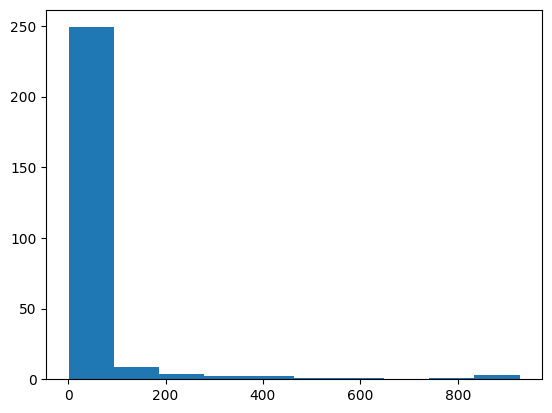

In [20]:
plt.hist(drugs)

In [21]:
summary = (
    all_merged.groupby(["treatments.therapeutic_agents", "recist_label"])
    .size()
    .reset_index(name="count")
)
pivot = summary.pivot(
    index="treatments.therapeutic_agents", columns="recist_label", values="count"
).fillna(0)
pivot["total_samples"] = pivot.sum(axis=1)  # Unknown があれば自動で加算
pivot["total_known"] = pivot.get(0, 0) + pivot.get(1, 0)
col_order = [0, 1, "total_known", "Unknown", "total_samples"]  # 3番目に total_known
pivot = pivot[col_order]
pivot_sorted = pivot.sort_values("total_known", ascending=False)
pivot_sorted.head()

recist_label                      0      1  total_known  Unknown  \
treatments.therapeutic_agents                                      
Cisplatin                      95.0  324.0        419.0    404.0   
Fluorouracil                   79.0  191.0        270.0    215.0   
Carboplatin                    87.0  171.0        258.0    618.0   
Paclitaxel                     67.0  170.0        237.0    690.0   
Cyclophosphamide               17.0  156.0        173.0    429.0   

recist_label                   total_samples  
treatments.therapeutic_agents                 
Cisplatin                              823.0  
Fluorouracil                           485.0  
Carboplatin                            876.0  
Paclitaxel                             927.0  
Cyclophosphamide                       602.0

In [22]:
pivot_sorted.sum()

recist_label
0                 1232.0
1                 2113.0
total_known       3345.0
Unknown           7345.0
total_samples    10690.0
dtype: float64

In [23]:
# 薬 × Project の出現回数をクロス集計
drug_project_matrix = (
    all_merged.groupby(["treatments.therapeutic_agents", "project.project_id"])
    .size()
    .reset_index(name="count")
    .pivot(
        index="treatments.therapeutic_agents",
        columns="project.project_id",
        values="count",
    )
    .fillna(0)
)

# プロジェクト数でソート
drug_project_matrix["num_projects"] = (drug_project_matrix > 0).sum(axis=1)
drug_project_matrix_sorted = drug_project_matrix.sort_values(
    "num_projects", ascending=False
)

# num_projects列はヒートマップには不要なので除く
heatmap_data = drug_project_matrix_sorted.drop(columns=["num_projects"])

# 図の大きさを薬とプロジェクト数に合わせて設定
n_drugs, n_projects = heatmap_data.shape
plt.figure(figsize=(n_projects * 0.5, n_drugs * 0.5))

# Log変換
heatmap_data_log = np.log1p(heatmap_data)

# 各薬が出現しているプロジェクト数
drug_project_counts = (heatmap_data > 0).sum(axis=1)

# 出現プロジェクト数でソート（多い順）
heatmap_data_sorted = heatmap_data.loc[
    drug_project_counts.sort_values(ascending=False).index
]
heatmap_data_log_sorted = heatmap_data_log.loc[heatmap_data_sorted.index]

# ラベル作成
drug_labels = [
    f"{drug} ({int(heatmap_data_sorted.loc[drug].sum())})"
    for drug in heatmap_data_sorted.index
]
project_labels = [
    f"{proj} ({int(heatmap_data_sorted[proj].sum())})"
    for proj in heatmap_data_sorted.columns
]

# 0 を白、それ以外は magma
colors = [(1, 1, 1)] + sns.color_palette("magma", 255)
cmap = LinearSegmentedColormap.from_list("magma_white0", colors, N=256)

# 描画サイズ
plt.figure(figsize=(len(project_labels) * 0.5, len(drug_labels) * 0.5), dpi=300)

# 全体フォント設定
plt.rcParams.update({"font.size": 12, "font.family": "Arial"})

sns.heatmap(
    heatmap_data_log_sorted,
    cmap=cmap,
    linewidths=0.5,
    yticklabels=drug_labels,
    xticklabels=project_labels,
    square=True,
)

plt.title(
    "Drug × TCGA Project Counts (Sorted by number of projects)",
    fontsize=12,
    fontname="Arial",
)
plt.xlabel("TCGA Project", fontsize=12, fontname="Arial")
plt.ylabel("Drug", fontsize=12, fontname="Arial")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

<Figure size 1550x13600 with 0 Axes>